In [1]:
#Install Py Package from: https://github.com/hootnot/oanda-api-v20
#https://oanda-api-v20.readthedocs.io/en/latest/oanda-api-v20.html

import json
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
#from exampleauth import exampleAuth

import datetime as DT

import pandas as pd
from pandas.io.json import json_normalize

from scipy.signal import savgol_filter as smooth
import matplotlib.pyplot as plt

import numpy as np

In [2]:
def exampleAuth():
    accountID, token = None, None
    with open("./oanda_account/account.txt") as I:
        accountID = I.read().strip()
    with open("./oanda_account/token.txt") as I:
        token = I.read().strip()
    return accountID, token

In [3]:
accountID, access_token = exampleAuth()
client = oandapyV20.API(access_token=access_token)

In [4]:
today = DT.date.today()
two_years_ago = today - DT.timedelta(days=720)

t = today.timetuple()
y = two_years_ago.timetuple()

In [5]:
two_years_ago

datetime.date(2018, 5, 6)

In [6]:
instrument = "EUR_USD"
params = {
    "from": "2018-01-01T00:00:00Z",
    "granularity": "D",
    "count": 720,
}
r = instruments.InstrumentsCandles(instrument=instrument, params=params)
response = client.request(r)
#print("Request: {}  #candles received: {}".format(r, len(r.response.get('candles'))))
#print(json.dumps(response, indent=2))

In [7]:
df = pd.DataFrame(response['candles']).set_index('time')

In [8]:
df = df['mid']

In [9]:
time_df = pd.DataFrame(response['candles'])
time = time_df['time']

In [10]:
df = json_normalize(df).astype(float)

In [11]:
df = pd.merge(df, time, how='inner', left_index=True, right_index=True)

In [12]:
df['just_date'] = pd.to_datetime(df['time']).dt.date

In [13]:
#df

In [14]:
#df = df.set_index('just_date')

In [15]:
#df

In [16]:
df.dtypes

o            float64
h            float64
l            float64
c            float64
time          object
just_date     object
dtype: object

In [17]:
close = df['c']

In [18]:
data = close.to_numpy()

In [19]:
#Set Lookback period
time = 20

In [20]:
def support(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """

    # converting n to a nearest even number
    if n % 2 != 0:
        n += 1

    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n + 1), 3)

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])

    resistance = []
    support = []

    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i + n)]
        first = arr_sl[:(n // 2)]  # first half
        last = arr_sl[(n // 2):]  # second half

        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n // 2)) and (r_2 == (n // 2)):
            resistance.append(ltp[i + ((n // 2) - 1)])

        # local minima detection
        if (s_1 == (n // 2)) and (s_2 == (n // 2)):
            support.append(ltp[i + ((n // 2) - 1)])

    return support


In [21]:
sup = support(data, time)

In [22]:
df_sup = pd.DataFrame(sup)
df_sup

,0
0,1.13436
1,1.08986
2,1.07916


In [23]:
def resistance(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """

    # converting n to a nearest even number
    if n % 2 != 0:
        n += 1

    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n + 1), 3)

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])

    resistance = []
    support = []

    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i + n)]
        first = arr_sl[:(n // 2)]  # first half
        last = arr_sl[(n // 2):]  # second half

        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n // 2)) and (r_2 == (n // 2)):
            resistance.append(ltp[i + ((n // 2) - 1)])

        # local minima detection
        if (s_1 == (n // 2)) and (s_2 == (n // 2)):
            support.append(ltp[i + ((n // 2) - 1)])

    return resistance

In [24]:
res = resistance(data, time)


In [25]:
df_res = pd.DataFrame(res)
df_res

,0
0,1.24024
1,1.13694
2,1.10795
3,1.11512
4,1.14400


In [26]:
#start_date = df.just_date.min()
#end_date = df.just_date.max()
#support_line = 1.0800

In [27]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import Span
from math import pi

In [28]:
inc = df.c > df.o
dec = df.o > df.c
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

In [29]:
p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = instrument + "Currency Pair")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3



In [30]:
# Horizontal line
#for line in sup:
#    hline_sup = Span(location=sup, dimension='width', line_color='green', line_width=3)
#    hline_res = Span(location=sup, dimension='width', line_color='red', line_width=3)
#


In [31]:
p.segment(df.just_date, df.h, df.just_date, df.l, color="black")
p.vbar(df.just_date[inc], w, df.o[inc], df.c[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.just_date[dec], w, df.o[dec], df.c[dec], fill_color="#F2583E", line_color="black")



for i in df_res[0]:
    #print (i)
    hline_res = Span(location=i, dimension='width', line_color='green', line_width=3)
    hline_sup = Span(location=i, dimension='width', line_color='red', line_width=3)
    p.renderers.extend([hline_res])
    
for i in df_sup[0]:
    #print (i)
    hline_sup = Span(location=i, dimension='width', line_color='red', line_width=3)
    p.renderers.extend([hline_sup])

#p.renderers.extend([hline])

In [32]:
output_file(instrument+".html", title=instrument+" Currency Pair")

show(p)  # open a browser

In [33]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show

#toy_df = pd.DataFrame(data=np.random.rand(5,3), columns = ('a', 'b' ,'c'), index = pd.DatetimeIndex(start='01-01-2015',periods=5, freq='d'))   

ts_list_of_list = []
for i in range(0,len(df_sup.columns)):
    ts_list_of_list.append(df_sup.index)

vals_list_of_list = df_sup.values.T.tolist()

p = figure(width=1200, height=900, x_axis_type="datetime") 
p.multi_line(ts_list_of_list, vals_list_of_list)
show(p)

TypeError: bad operand type for unary +: 'str'

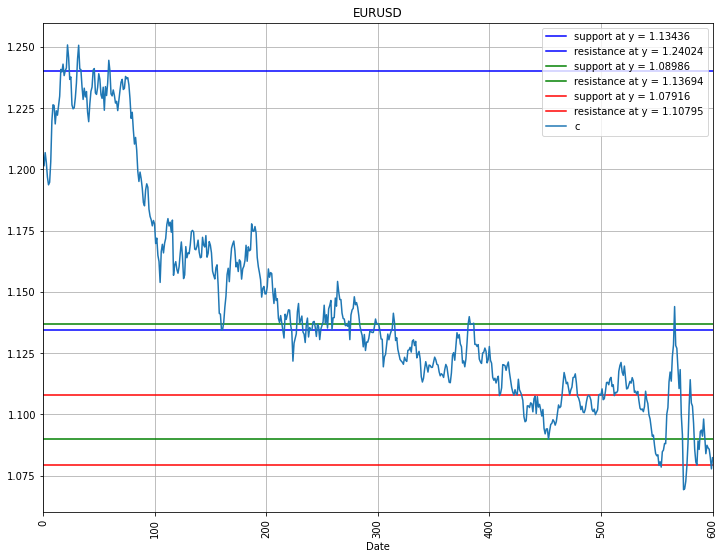

In [34]:
title = 'EURUSD'
ycoords_sup = sup
ycoords_res = res
# colors for the lines
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for ycs,ycr,c in zip(ycoords_sup,ycoords_res,colors):
    plt.axhline(y=ycs, label='support at y = {}'.format(ycs), c=c)
    plt.axhline(y=ycr, label='resistance at y = {}'.format(ycr), c=c)
close.plot(figsize=(12,9),grid=True, title = title)

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.legend()

# Create new directory
output_dir = "/home/routinelife/labs.neuralmarkettrends.com"
# mkdir_p(output_dir)


plt.savefig(+ title + '-chart.png')
plt.show()



#fig.savefig('{}/graph.png'.format(output_dir))

In [ ]:
#TODO, add in 'squishy zones'